# Tiny Shakespeare Dataset Analysis

This notebook analyzes the Tiny Shakespeare dataset, preprocessed and tokenized using the **custom BPE tokenizer**.

Analysis includes:
1.  Vocabulary Size (from custom tokenizer)
2.  Sequence Length Statistics (based on lines in the cleaned text)
3.  Token Frequency Distribution

In [16]:
import os
import sys
import json
import numpy as np
import matplotlib.pyplot as plt
import time
from collections import Counter

print("Setting up environment and importing libraries...")

# --- Path Setup ---
# Add the directory containing tokenizer.py to the Python path
# Assumes notebook is in 'notebooks/' and tokenizer.py is in 'data/'
data_module_path = os.path.abspath(os.path.join('..', 'data'))
if data_module_path not in sys.path:
    sys.path.append(data_module_path)
print(f"Added '{data_module_path}' to sys.path")

# --- Import Custom Tokenizer Class ---
try:
    # Import the custom GPT2Tokenizer class YOU created
    from tokenizer import GPT2Tokenizer
    print("Successfully imported custom GPT2Tokenizer class.")
except ImportError as e:
    print(f"Error importing tokenizer: {e}")
    print(f"Ensure your custom tokenizer.py is present in '{data_module_path}'")
    raise # Stop execution if class cannot be imported

print("Setup complete.")

Setting up environment and importing libraries...
Added 'C:\Users\tsatt\Downloads\As tokenizer task\repo\mini-GPT2\data' to sys.path
Successfully imported custom GPT2Tokenizer class.
Setup complete.


## 1. Configuration and File Verification

Define paths to the relevant dataset files generated by `preprocess.py` (using the custom tokenizer) and verify their existence.

In [17]:
# Define paths relative to the 'notebooks/' directory
DATA_DIR = os.path.abspath(os.path.join('..', 'data', 'shakespeare'))
CLEAN_FILE = os.path.join(DATA_DIR, "clean_input.txt") # Input for line analysis
VOCAB_FILE = os.path.join(DATA_DIR, "vocab.json")     # Custom vocab/merges
TRAIN_BIN = os.path.join(DATA_DIR, "train.bin")      # Custom token IDs
VAL_BIN = os.path.join(DATA_DIR, "val.bin")        # Custom token IDs

print(f"Expected Data Directory: {DATA_DIR}")
print(f"Cleaned Text File: {CLEAN_FILE}")
print(f"Vocabulary File: {VOCAB_FILE}")
print(f"Train Binary File: {TRAIN_BIN}")
print(f"Validation Binary File: {VAL_BIN}")
print("-" * 20)

# Verify files exist
print(f"Checking file existence:")
clean_exists = os.path.exists(CLEAN_FILE)
vocab_exists = os.path.exists(VOCAB_FILE)
train_exists = os.path.exists(TRAIN_BIN)
val_exists = os.path.exists(VAL_BIN)

print(f"  clean_input.txt exists: {clean_exists}")
print(f"  vocab.json exists: {vocab_exists}")
print(f"  train.bin exists: {train_exists}")
print(f"  val.bin exists: {val_exists}")

# Basic check if we can proceed
if not all([clean_exists, vocab_exists, train_exists, val_exists]):
     print("\nError: Not all required data files found.")
     print("Please ensure preprocess.py using the custom tokenizer ran successfully.")
     # Stop execution by raising an error
     raise FileNotFoundError("Missing required data files generated by preprocess.py")
else:
    print("\nAll required data files found.")

Expected Data Directory: C:\Users\tsatt\Downloads\As tokenizer task\repo\mini-GPT2\data\shakespeare
Cleaned Text File: C:\Users\tsatt\Downloads\As tokenizer task\repo\mini-GPT2\data\shakespeare\clean_input.txt
Vocabulary File: C:\Users\tsatt\Downloads\As tokenizer task\repo\mini-GPT2\data\shakespeare\vocab.json
Train Binary File: C:\Users\tsatt\Downloads\As tokenizer task\repo\mini-GPT2\data\shakespeare\train.bin
Validation Binary File: C:\Users\tsatt\Downloads\As tokenizer task\repo\mini-GPT2\data\shakespeare\val.bin
--------------------
Checking file existence:
  clean_input.txt exists: True
  vocab.json exists: True
  train.bin exists: True
  val.bin exists: True

All required data files found.


## 2. Load Custom Tokenizer & Analyze Vocabulary

Load the state of the custom BPE tokenizer from `vocab.json` and report its vocabulary size.

In [18]:
print("Loading custom BPE tokenizer state...")
tokenizer = GPT2Tokenizer() # Instantiate your custom class

try:
    tokenizer.load_vocabulary(VOCAB_FILE)
    print(f"Tokenizer state loaded successfully from {VOCAB_FILE}")

    # --- Vocabulary Analysis ---
    if hasattr(tokenizer, 'token_to_id') and tokenizer.token_to_id:
        vocab_size = len(tokenizer.token_to_id)
        print(f"--> Vocabulary Size: {vocab_size}")
        # Check if UNK token loaded correctly
        if tokenizer.unk_token and tokenizer.unk_token_id is not None:
             print(f"    UNK token '{tokenizer.unk_token}' found with ID: {tokenizer.unk_token_id}")
        else:
             print("    Warning: UNK token information missing or not loaded correctly.")
    else:
        print("Error: Tokenizer loaded, but token_to_id map is empty or missing.")
        raise ValueError("Failed to load vocabulary properly.")

except FileNotFoundError:
    print(f"Error: Vocabulary file not found at {VOCAB_FILE}.")
    raise # Stop execution
except Exception as e:
    print(f"Error loading vocabulary: {e}")
    raise # Stop execution

Loading custom BPE tokenizer state...
Tokenizer state loaded successfully from C:\Users\tsatt\Downloads\As tokenizer task\repo\mini-GPT2\data\shakespeare\vocab.json
--> Vocabulary Size: 5000
    UNK token '[UNK]' found with ID: 65


## 3. Sequence Length Statistics (Based on Lines)

Analyze the length (in tokens using the custom tokenizer) of each line in the `clean_input.txt` file.

In [19]:
lines = []
line_token_lengths = []

print(f"Loading cleaned text from {CLEAN_FILE} for line analysis...")
try:
    with open(CLEAN_FILE, 'r', encoding='utf-8') as f:
        cleaned_text = f.read()
    print(f"Loaded {len(cleaned_text)} characters.")

    # Split text into lines
    lines = cleaned_text.splitlines()
    # Filter out empty lines (those containing only whitespace after strip)
    lines = [line for line in lines if line.strip()]
    num_lines = len(lines)
    print(f"Found {num_lines} non-empty lines to analyze.")

except FileNotFoundError:
    print(f"Error: Cleaned file not found at {CLEAN_FILE}")
except Exception as e:
    print(f"Error reading or processing cleaned file: {e}")

Loading cleaned text from C:\Users\tsatt\Downloads\As tokenizer task\repo\mini-GPT2\data\shakespeare\clean_input.txt for line analysis...
Loaded 1108152 characters.
Found 32777 non-empty lines to analyze.


In [20]:
if lines and 'tokenizer' in locals() and hasattr(tokenizer, 'encode'):
    print(f"Tokenizing {num_lines} lines using the loaded custom tokenizer (this might take a moment)...")
    start_time = time.time()
    line_token_lengths = []
    for i, line in enumerate(lines):
        # Use the encode method of your loaded custom tokenizer
        tokens = tokenizer.encode(line)
        line_token_lengths.append(len(tokens))
        # Print progress update periodically
        if (i + 1) % 5000 == 0:
             elapsed = time.time() - start_time
             print(f"  Processed {i+1}/{num_lines} lines... ({elapsed:.2f} seconds)")

    end_time = time.time()
    print(f"Finished tokenizing lines in {end_time - start_time:.2f} seconds.")
else:
    print("Skipping line tokenization as prerequisites (lines, tokenizer) are not met.")

Tokenizing 32777 lines using the loaded custom tokenizer (this might take a moment)...
  Processed 5000/32777 lines... (28.51 seconds)
  Processed 10000/32777 lines... (59.73 seconds)
  Processed 15000/32777 lines... (92.63 seconds)
  Processed 20000/32777 lines... (124.72 seconds)
  Processed 25000/32777 lines... (155.52 seconds)
  Processed 30000/32777 lines... (184.92 seconds)
Finished tokenizing lines in 200.69 seconds.


### Line Length Statistics Summary

In [21]:
if line_token_lengths:
    lengths_arr = np.array(line_token_lengths)

    min_len = np.min(lengths_arr)
    max_len = np.max(lengths_arr)
    avg_len = np.mean(lengths_arr)
    median_len = np.median(lengths_arr)
    std_dev = np.std(lengths_arr)
    p95 = np.percentile(lengths_arr, 95)
    total_tokens_lines = np.sum(lengths_arr) # For comparison later

    print(f"Analyzed {len(lengths_arr)} non-empty lines.")
    print(f"Total tokens counted across these lines: {total_tokens_lines}")
    print(f"\n--- Statistics for Tokens per Line (Custom BPE) ---")
    print(f"  Minimum:          {min_len}")
    print(f"  Maximum:          {max_len}")
    print(f"  Average (Mean):   {avg_len:.2f}")
    print(f"  Median:           {median_len}")
    print(f"  Standard Deviation: {std_dev:.2f}")
    print(f"  95th Percentile:  {p95:.2f}")
    print("-" * 45)
else:
    print("No line length data available to calculate statistics.")

Analyzed 32777 non-empty lines.
Total tokens counted across these lines: 430571

--- Statistics for Tokens per Line (Custom BPE) ---
  Minimum:          1
  Maximum:          31
  Average (Mean):   13.14
  Median:           16.0
  Standard Deviation: 7.23
  95th Percentile:  22.00
---------------------------------------------


### Line Length Distribution Plot

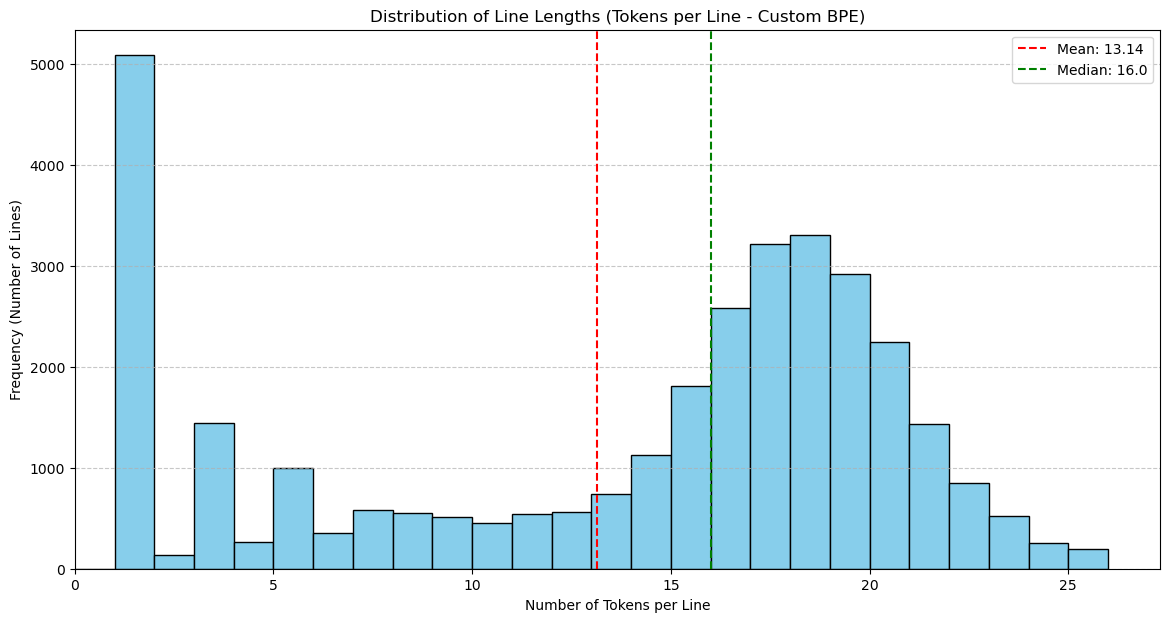

In [22]:
if line_token_lengths:
    plt.figure(figsize=(14, 7))
    # Determine reasonable bins, maybe up to the 95th percentile or max
    max_bin = min(int(p95 * 1.2), max_len) if 'p95' in locals() else max_len
    bins = min(50, max_bin) if max_bin > 0 else 10

    plt.hist(lengths_arr, bins=bins, color='skyblue', edgecolor='black', range=(0, max_bin))
    # Add vertical lines for mean and median
    if 'avg_len' in locals():
        plt.axvline(avg_len, color='red', linestyle='dashed', linewidth=1.5, label=f'Mean: {avg_len:.2f}')
    if 'median_len' in locals():
        plt.axvline(median_len, color='green', linestyle='dashed', linewidth=1.5, label=f'Median: {median_len}')

    plt.title('Distribution of Line Lengths (Tokens per Line - Custom BPE)')
    plt.xlabel('Number of Tokens per Line')
    plt.ylabel('Frequency (Number of Lines)')
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.xlim(left=0)
    plt.show()
else:
    print("No line length data available to plot.")

## 4. Token Frequency Distribution

Analyze the frequency of individual tokens in the combined training and validation sets (`train.bin`, `val.bin`).

In [23]:
print("Loading tokenized data from .bin files for frequency analysis...")
try:
    train_ids = np.fromfile(TRAIN_BIN, dtype=np.uint16) # Ensure dtype matches preprocess.py
    val_ids = np.fromfile(VAL_BIN, dtype=np.uint16)     # Ensure dtype matches preprocess.py
    all_token_ids = np.concatenate((train_ids, val_ids))
    total_tokens_bin = len(all_token_ids)
    print(f"Loaded {len(train_ids)} train tokens and {len(val_ids)} val tokens.")
    print(f"Total tokens from .bin files: {total_tokens_bin}")

    # Count token frequencies
    print("Counting token frequencies...")
    start_time = time.time()
    token_counts = Counter(all_token_ids)
    end_time = time.time()
    print(f"Counted frequencies in {end_time - start_time:.2f} seconds.")

    # Optional: Compare total token count with line analysis count
    if 'total_tokens_lines' in locals():
        print(f"\nComparison with line-by-line token count:")
        print(f"  Total tokens from lines:    {total_tokens_lines}")
        diff = total_tokens_bin - total_tokens_lines
        print(f"  Difference (bin - lines): {diff}")
        if diff != 0:
             print("  (Note: Differences can occur due to EOL handling, empty lines, whitespace tokens, etc.)")

except FileNotFoundError:
    print(f"Error: Could not find .bin files at {TRAIN_BIN} or {VAL_BIN}")
    token_counts = None
except Exception as e:
    print(f"Error loading or processing .bin files: {e}")
    token_counts = None

Loading tokenized data from .bin files for frequency analysis...
Loaded 417012 train tokens and 46335 val tokens.
Total tokens from .bin files: 463347
Counting token frequencies...
Counted frequencies in 0.07 seconds.

Comparison with line-by-line token count:
  Total tokens from lines:    430571
  Difference (bin - lines): 32776
  (Note: Differences can occur due to EOL handling, empty lines, whitespace tokens, etc.)


### Most Frequent Tokens

In [24]:
if token_counts and 'tokenizer' in locals() and hasattr(tokenizer, 'id_to_token'):
    N = 50 # Number of top tokens to display
    most_common_tokens = token_counts.most_common(N)

    print(f"\n--- Top {N} Most Frequent Tokens (Custom BPE) ---")
    print(f"{'Rank':<5} {'Token':<15} {'Token ID':<10} {'Count':<10}")
    print("-" * 45)
    for rank, (token_id, count) in enumerate(most_common_tokens):
        # Get the token string from the ID using the loaded tokenizer
        token_str = tokenizer.id_to_token.get(token_id, f"ID_{token_id}")
        # Use repr() to make whitespace/control characters visible
        print(f"{rank+1:<5} {repr(token_str):<15} {token_id:<10} {count:<10}")
    print("-" * 45)
else:
    print("Token frequency data or tokenizer not available.")


--- Top 50 Most Frequent Tokens (Custom BPE) ---
Rank  Token           Token ID   Count     
---------------------------------------------
1     ' '             1          169874    
2     '\n'            0          32776     
3     'the'           71         5483      
4     'I'             21         4464      
5     'to'            81         4083      
6     'and'           82         3736      
7     'of'            90         3342      
8     'a'             39         2934      
9     'my'            97         2701      
10    'in'            69         2500      
11    '.'             8          2428      
12    'you'           84         2158      
13    ';'             11         1983      
14    'is'            73         1919      
15    'that'          117        1827      
16    ','             6          1819      
17    'And'           119        1801      
18    ':'             10         1743      
19    'be'            94         1733      
20    'not'           11

### Token Frequency Plot

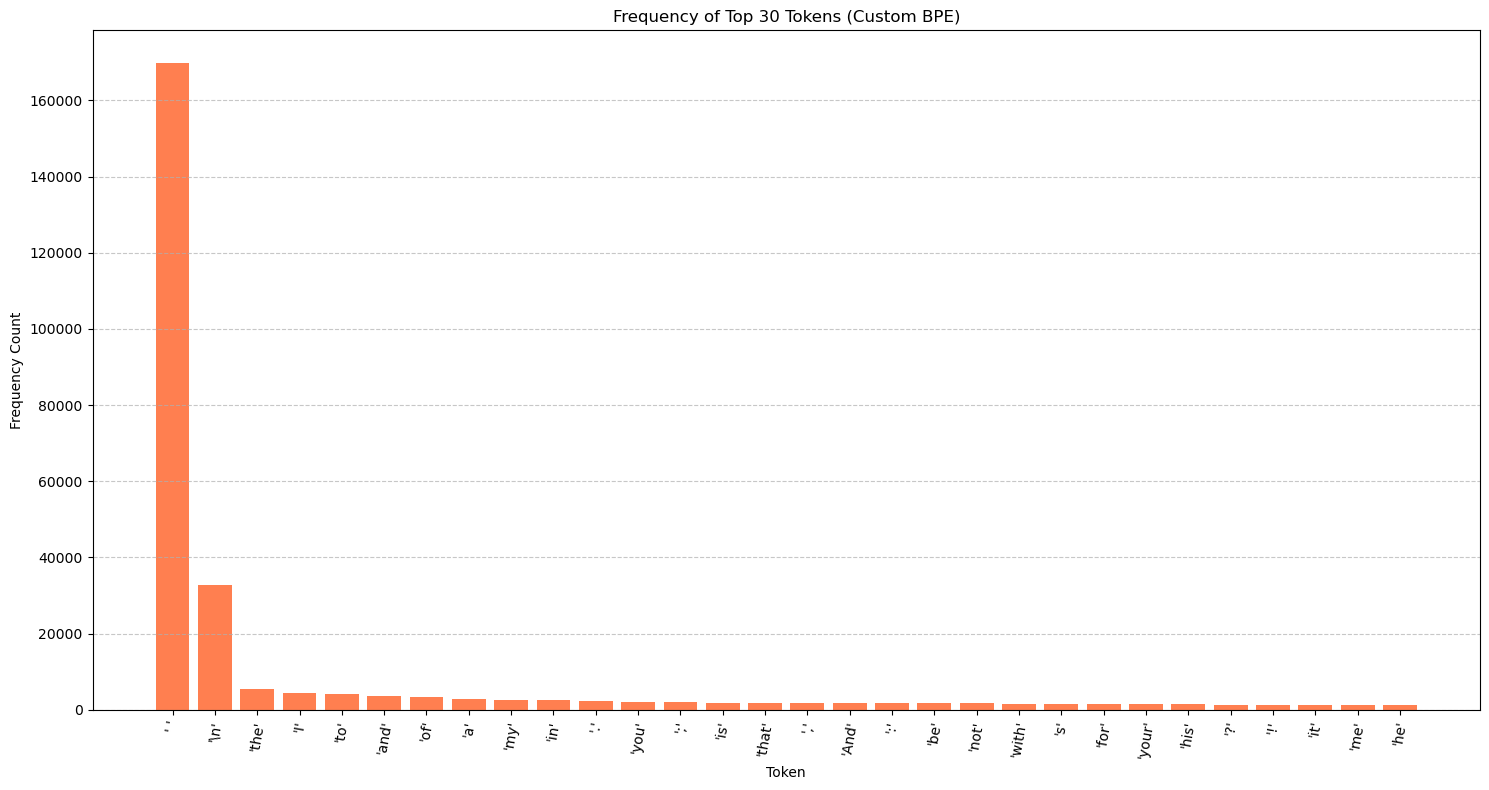

In [25]:
if token_counts and 'tokenizer' in locals() and hasattr(tokenizer, 'id_to_token'):
    N_plot = 30 # Number of top tokens to plot
    most_common_plot = token_counts.most_common(N_plot)

    # Prepare data for plotting
    token_ids_plot = [item[0] for item in most_common_plot]
    counts_plot = [item[1] for item in most_common_plot]
    # Get token string representations for labels
    token_labels_plot = [repr(tokenizer.id_to_token.get(tid, f"ID_{tid}")) for tid in token_ids_plot]

    plt.figure(figsize=(15, 8))
    plt.bar(range(N_plot), counts_plot, tick_label=token_labels_plot, color='coral')
    plt.xlabel('Token')
    plt.ylabel('Frequency Count')
    plt.title(f'Frequency of Top {N_plot} Tokens (Custom BPE)')
    plt.xticks(rotation=80) # Rotate labels for better visibility
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout() # Adjust layout to prevent labels overlapping
    plt.show()

else:
    print("Token frequency data or tokenizer not available for plotting.")

---